In [1]:
%matplotlib inline

# Raw datasets

Accessing raw array data from an experiment.

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from e11 import H5Data

## hdf5 file

In [3]:
import os 
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
# read hdf5 file
h5 = H5Data(fil)
h5.pprint()

100%|██████████| 6/6 [00:00<00:00, 471.20it/s]

file: 		 /home/adam/Git/e11_analysis/notebooks/example_data/array_data.h5 
size: 		 19.80 MB 
groups: 	 6 
author: 	 AD 
description: 	 Testing oskar data acquisition.


In [4]:
# List the datasets that belong to the group `squid=1`.
print(h5.datasets(1))

('AV_0', 'IMG', 'OSC_0')


## Array datasets

### Oscilloscope data

Oscilloscope traces are often stored as 2d arrays of repeating 1d measurements.

In [5]:
# Load 2D array data from the hdf5 file,
squid = 1
dat, osc_info = h5.array(squid, dataset='OSC_0', ignore_missing=False, info=True)

100%|██████████| 1/1 [00:00<00:00, 233.17it/s]


This data contains traces of 2501 data points and 25 repeats are stored along the first dimension.


In [6]:
print(np.shape(dat))

(25, 2502)


In [7]:
# information about the dataset.
osc_info

,Averages,Manufacturer,Model,Serial Number,dt
squid,,,,,
1,10,LECROY,HDO4054,LCRY3513N19955,8.000000e-10


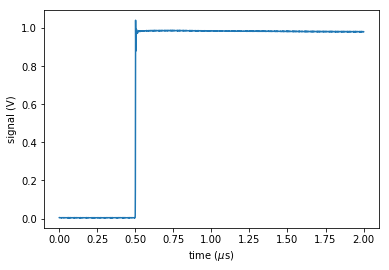

In [8]:
# plot
fig, ax = plt.subplots()

# data
dt = 1e6 * osc_info['dt']
xvals = np.arange(0, len(dat[0])*dt, dt)
yvals = np.mean(dat, axis=0)
ax.plot(xvals, yvals)

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('signal (V)')

# output
plt.show()

### Camera data

Camera data are typically stored as 3d arrays of repeating 2d exposures.  Here, the repeats are stored along axis=2, in accordance with the convention of `HDFView`.

In [9]:
# read image datasets
squids = [1, 2]
img, camera_info = h5.array(squids, dataset='IMG', axis=2, ignore_missing=True, info=True)

100%|██████████| 2/2 [00:00<00:00, 269.09it/s]


The data contains 19 images of 128 x 128 pixels. Concatenation of multiple squids is performed using `axis=2`.

In [10]:
print(np.shape(img))

(128, 128, 19)


In [11]:
# information about the dataset
camera_info

,Exposure (ms),Manufacturer,Model
squid,,,
1,1000,Sirius Cybernetics Corporation,image-o-matic


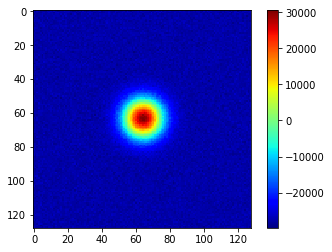

In [12]:
# average image
av_img = np.mean(img, axis=2)
cmap = 'jet'

# plot
fig, ax = plt.subplots()
image = ax.imshow(av_img, cmap=cmap)
cb = plt.colorbar(image)

# output
plt.show()

## Dataframe datasets

Another common data storage format is the dataframe-like structure, i.e., single values stored as rows in headed columns.

In [13]:
# load data from the hdf5 file,
df, df_info = h5.df(squids=h5.squids, dataset='AV_0', label=None, ignore_missing=False, info='all')
df.head()

100%|██████████| 6/6 [00:00<00:00, 261.21it/s]


AB        CD        EF
squid repeat                              
1     0       0.983765  0.984008  0.004351
      1       0.984163  0.984424  0.004799
      2       0.983991  0.984383  0.004606
      3       0.983983  0.984222  0.004568
      4       0.983856  0.984048  0.004349

In this example, AV_0 is the mean oscilloscope signal in a given window.  The window boundaries are stored as dataset attributes, here returned as `df_info`.

In [14]:
df_info

,A,B,C,D,E,F
squid,,,,,,
1,2127,893,646,709,133,437
2,2127,893,646,709,133,437
3,2127,893,646,709,133,437
4,2127,893,646,709,133,437
5,2127,893,646,709,133,437
6,2127,893,646,709,133,437


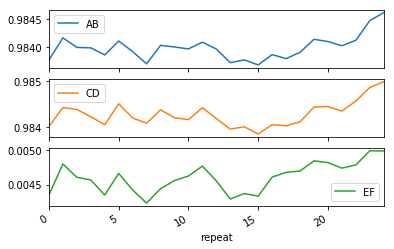

In [15]:
# plot the DataFrame for squid=1
df.loc[1, :].plot(subplots=True)

# output
plt.show()

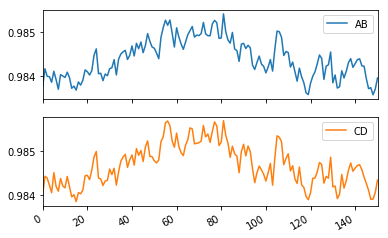

In [16]:
# plot the DataFrame for all squids
df.reset_index()[['AB', 'CD']].plot(subplots=True)

# output
plt.show()